# Energy Injection in 1D Brown Dwarf Climate Models

In this tutorial you will learn how you can add in an arbitrary amount of energy into your climate model. This could be because you want to build an intuition on the impact of temperature inversions or see if there are hot spots in your object causing variability in the observations for example. 

You should be comfortable with running climate models by now, the minimum requirement for this tutorial is [One-Dimensional Climate Models: The Basics of Brown Dwarfs](https://natashabatalha.github.io/picaso/notebooks/climate/12a_BrownDwarf.html).

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import virga.justdoit as vj
import virga.justplotit as cldplt
jpi.output_notebook()
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray
from bokeh.plotting import show, figure
import pandas as pd

Loading BokehJS ...

## Analytical Energy Injection

In this part of the tutorial we are going to be comparing our climate models with those from [Morley et al. 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...789L..14M/abstract). We are going to test the case for a 600 K brown dwarf. To inject the energy into the atmosphere we are going to use the Chapman function to describe the profile of the energy deposition. The Chapman function is selected because it is often used
to represent heating by incident flux within molecular bands.

We are going to initiate our profile just like any other basic climate model first

In [ ]:
# #1 ck tables from roxana
mh = '+000'#'+0.0' #log metallicity
CtoO = '100'#'1.0' # CtoO ratio

ck_db = f'/data/kcoeff_2020_v3/sonora_2020_feh{mh}_co_{CtoO}.data.196'
#sonora bobcat cloud free structures file
sonora_profile_db = '/data/sonora_bobcat/structure/structures_m+0.0'

In [3]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation

teff= 600 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

opacity_ck = jdi.opannection(ck_db=ck_db,method='preweighted') # grab your opacities

In [4]:
nlevel = 91 # number of plane-parallel levels in your code

pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.cmp.gz"),
                            usecols=[1,2],unpack=True, skiprows = 1)

In [5]:
nofczns = 1 # number of convective zones initially

nstr_upper = 87 # top most level of guessed convective zone 

nstr_deep = nlevel - 2 # this is always the case. Dont change this

nstr = np.array([0,nstr_upper,nstr_deep,0,0,0])

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

In [6]:
cl_run.inputs_climate(temp_guess= temp_bobcat, pressure= pressure_bobcat,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv)

**New PICASO code parameters**: 

1. `inject_energy` : (True/False) Turns on energy injection. Default = False
2. `total_energy_injection` : (float) Desired total amount of energy to be deposited in units of ergs/cm^2/s
3. `press_max_energy` : (float) Pressure for maximum energy injection in units of bars for chapman function
4. `injection_scaleheight` :  (float) Scalar specifying the number of scale heights over which energy is deposited

In [ ]:
cl_run.energy_injection(inject_energy = True, total_energy_injection= 3.67e6,
                      press_max_energy = 1, injection_scalehight= 1)

In [8]:
out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

SUMMARY
-------
Clouds: False
quench False
cold_trap False
vol_rainout False
no_ph3 False
Moist Adiabat: False
Iteration number  0 , min , max temp  177.70335627794603 2257.4261381721617 , flux balance  -0.3230287894604597
Iteration number  1 , min , max temp  181.63960625912785 2265.766582601684 , flux balance  -0.3104956364915862
Iteration number  2 , min , max temp  185.50596571760306 2274.3583849058487 , flux balance  -0.29739025588018975
Iteration number  3 , min , max temp  189.3017236835273 2283.1999612602826 , flux balance  -0.2836962427227354
Iteration number  4 , min , max temp  193.02768536380248 2292.28880621252 , flux balance  -0.26939803158659076
Iteration number  5 , min , max temp  196.6857527431823 2301.62166516489 , flux balance  -0.25448072796931404
Iteration number  6 , min , max temp  200.2785695518667 2311.1946890454365 , flux balance  -0.238929952937327
Iteration number  7 , min , max temp  203.80926193118174 2321.0035682035123 , flux balance  -0.2227317058654246

In [9]:
# Now let's read in our benchmark profile from Morley et. al 2014
benchmark = pd.read_csv('t600g1000nc-3.67e6-h1-1bar.dat',skiprows=1, delim_whitespace=True)

#we only want to compare the P-T profile so we don't care about the other columns
benchmark.columns = ['level', 'pressure', 'temperature', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']

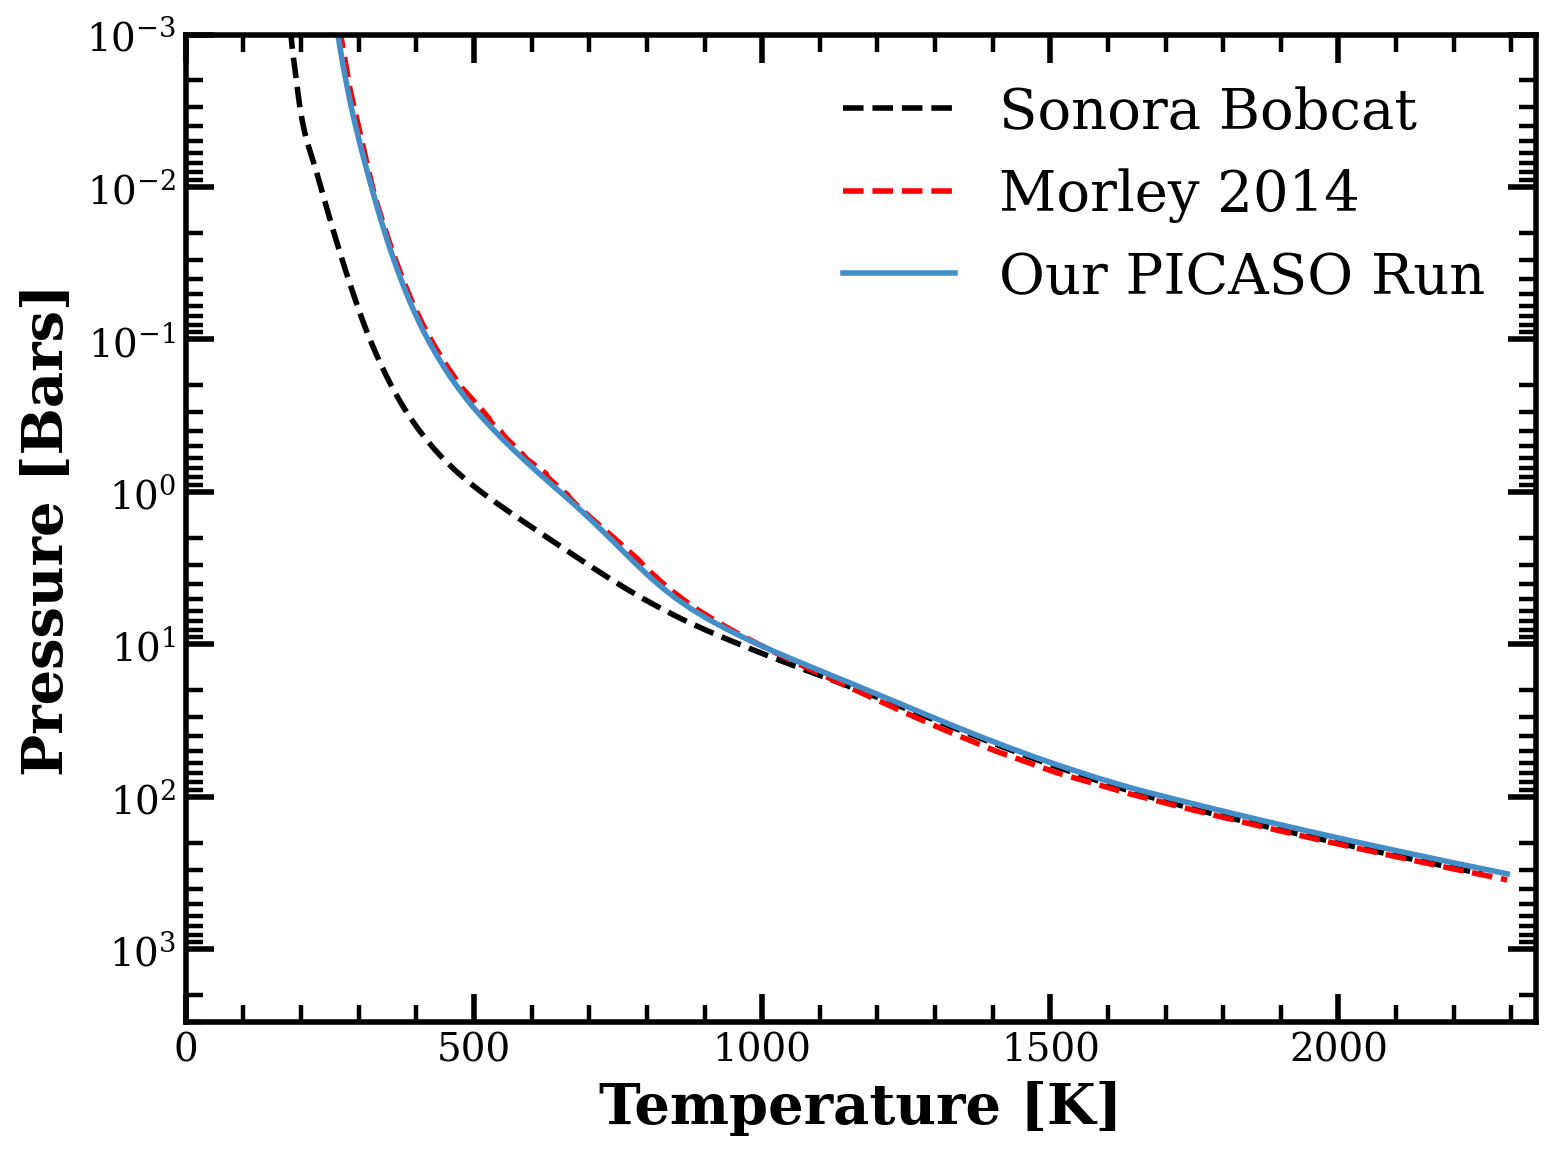

In [10]:
pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.cmp.gz"),
                            usecols=[1,2],unpack=True, skiprows = 1)
plt.figure(figsize=(8,6))
plt.ylabel("Pressure [Bars]")
plt.xlabel('Temperature [K]')
plt.xlim(0,max(out['temperature'])+50)
plt.ylim(3e3,1e-3)

plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",label="Sonora Bobcat")
plt.semilogy(benchmark['temperature'],benchmark['pressure'],color="r",linestyle="--",label="Morley 2014")
plt.semilogy(out['temperature'],out['pressure'],label="Our PICASO Run")

plt.legend()
plt.tight_layout()
plt.show()

When you generate these models, remember that because you artificially injected energy into the atmosphere, the profile will be **warmer** than the desired effective temperature that you set for the object. You might also notice here that there are the slightest difference in the PT profile between our model and the Morley 2014 model, we're not worried about this since we ran a 91 level model compared to their 60 level model.

## Numerical Energy Injection

Let's say you don't want to use something like the Chapman function because you have an actual profile of energy deposition you'd like to include in your model. We can add a couple of other inputs to do this.

In [11]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation

teff= 600 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

opacity_ck = jdi.opannection(ck_db=ck_db,method='preweighted') # grab your opacities

In [12]:
nlevel = 91 # number of plane-parallel levels in your code

pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.cmp.gz"),
                            usecols=[1,2],unpack=True, skiprows = 1)

In [13]:
nofczns = 1 # number of convective zones initially

nstr_upper = 87 # top most level of guessed convective zone 

nstr_deep = nlevel - 2 # this is always the case. Dont change this

nstr = np.array([0,nstr_upper,nstr_deep,0,0,0])

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

Here we're going to generate a Gaussian distribution of energy that will be injected into the upper atmosphere of this climate model just as an example how you can use any energy profile you'd like

In [14]:
from scipy.stats import norm

# Define the center and width of the Gaussian
center = 45  # Index for the peak of the Gaussian
width = 10    # Standard deviation of the Gaussian

# Create a Gaussian profile
beam_profile = norm.pdf(np.arange(len(pressure_bobcat)), loc=center, scale=width)

# Normalize the Gaussian to match the desired energy range
beam_profile = beam_profile / beam_profile.max() * 6e5  # Scale to the desired range

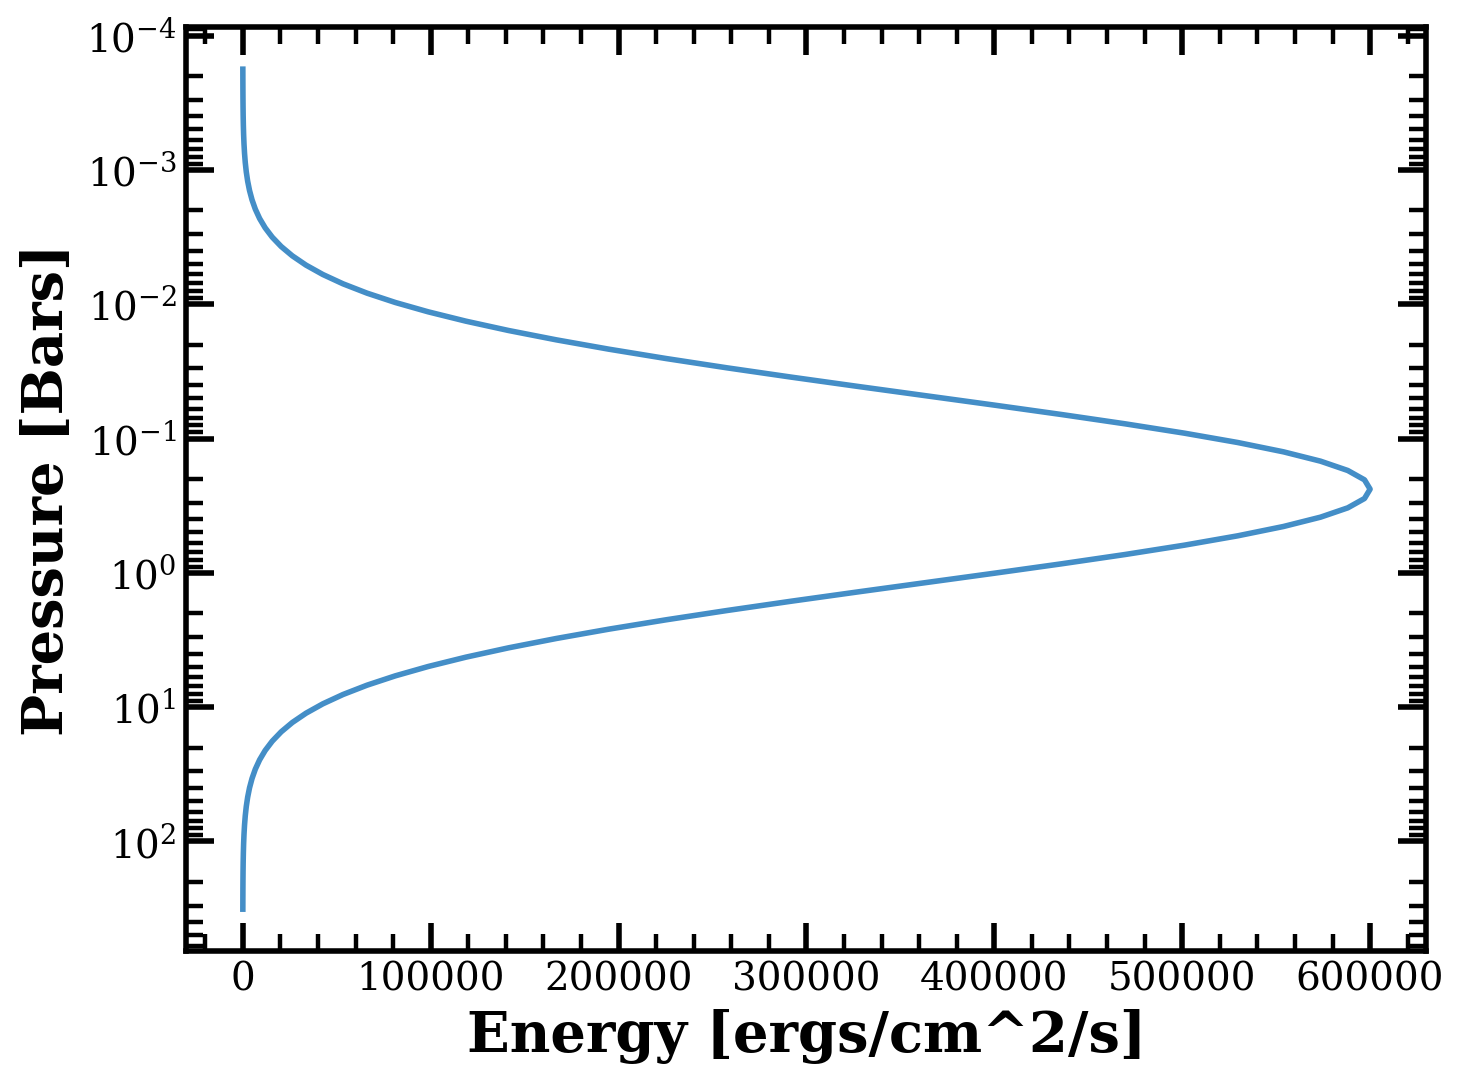

In [15]:
plt.semilogy(beam_profile, pressure_bobcat, label='Gaussian Energy Beam Profile')
plt.gca().invert_yaxis()
plt.xlabel('Energy [ergs/cm^2/s]')
plt.ylabel('Pressure [Bars]')
plt.show()

**New PICASO code parameters**: 

1. `inject_beam` : (bool) Turns on using your own energy profile instead of the Chapman function
2. `beam_profile` : (array) Array of the energy profile. The shape of this array needs to be the same as the pressure grid.

In [16]:
cl_run.inputs_climate(temp_guess= temp_bobcat, pressure= pressure_bobcat,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv)

cl_run.atmosphere(mh=mh, cto_relative=cto_relative, chem_method='visscher_1060')

cl_run.energy_injection(inject_energy = True, inject_beam = True, beam_profile = beam_profile)

In [17]:
out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

SUMMARY
-------
Clouds: False
quench False
cold_trap False
vol_rainout False
no_ph3 False
Moist Adiabat: False
Iteration number  0 , min , max temp  179.6444441888295 2249.4406035295797 , flux balance  -0.6724208874951241
Iteration number  1 , min , max temp  185.66826523284308 2249.5647971085154 , flux balance  -0.6720565098858716
Iteration number  2 , min , max temp  191.71943444491495 2249.703111327065 , flux balance  -0.6716504481405191
Iteration number  3 , min , max temp  197.7574195985674 2249.856778713471 , flux balance  -0.6711990182241392
Iteration number  4 , min , max temp  203.75320006228415 2250.026989518189 , flux balance  -0.6706986514311383
Iteration number  5 , min , max temp  209.6876194795645 2250.2148899173294 , flux balance  -0.670145899567948
Iteration number  6 , min , max temp  215.5491156869918 2250.421582539739 , flux balance  -0.6695374331904437
Iteration number  7 , min , max temp  221.3316763469807 2250.648127948734 , flux balance  -0.6688700369184457
Iter

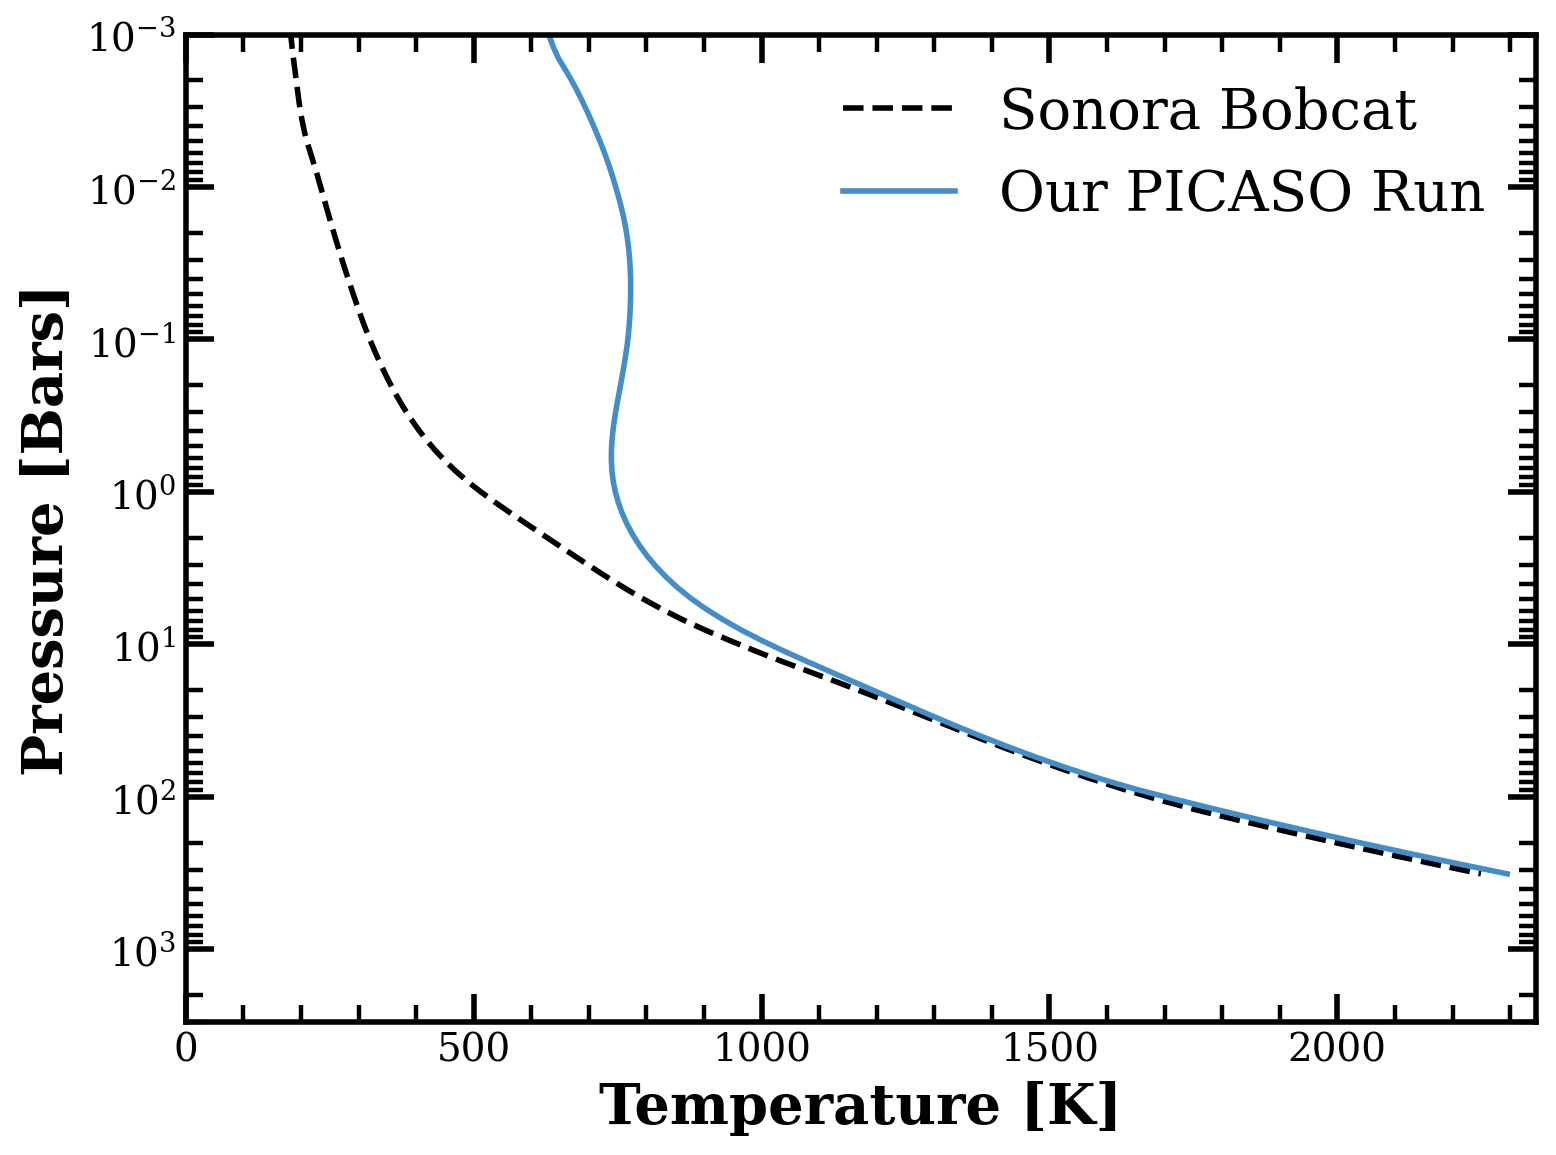

In [18]:
pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.cmp.gz"),
                            usecols=[1,2],unpack=True, skiprows = 1)
plt.figure(figsize=(8,6))
plt.ylabel("Pressure [Bars]")
plt.xlabel('Temperature [K]')
plt.xlim(0,max(out['temperature'])+50)
plt.ylim(3e3,1e-3)

plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",label="Sonora Bobcat")
plt.semilogy(out['temperature'],out['pressure'],label="Our PICASO Run")

plt.legend()
plt.tight_layout()
plt.show()